In [276]:
library(Seurat)
library(ggplot2)
library(stringr)
library(ggpubr)
library(viridis)
library(dplyr)
library(reshape2)
library(ggbeeswarm)
library(ggrastr)
library(RColorBrewer)

In [87]:
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=.355),
                     axis.line = element_line(linewidth = .355),
                     axis.ticks = element_line(linewidth = .177))
UMAP_theme <- theme_bw()+theme(axis.text.y = element_blank(),
                               axis.text.x = element_blank(),
                               axis.ticks.x= element_blank(),
                               axis.ticks.y= element_blank(),
                               axis.title.x= element_blank(),
                               axis.title.y= element_blank(),
                               strip.text.x = element_text(size = 8),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.border = element_blank(),
                               panel.background = element_rect(colour = "black", fill = NA,linewidth=.355),
                               legend.position = "none",
                               plot.title = element_text(hjust = 0.5, size = 8))

In [65]:
jz.checkgenes = function(srat,gene){
    genes = rownames(srat)
    return(genes[startsWith(genes,gene)])
}

In [282]:
jz.save.umap.coord <- function(object) {
    # saves the UMAP embedding to the metadata 
    umapCoord <- as.data.frame(Embeddings(object = object[["umap"]]))
    object@meta.data$UMAP1 = umapCoord$umap_1
    object@meta.data$UMAP2 = umapCoord$umap_2
    if ('UMAP_1' %in% colnames(umapCoord)) {
        object@meta.data$UMAP1 = umapCoord$UMAP_1
        object@meta.data$UMAP2 = umapCoord$UMAP_2        
    }
    return(object)
}

In [292]:
# transcriptome 
gex = readRDS('CompleteIntegrated_scRNA_SeuratObject.rds')
gex = UpdateSeuratObject(gex)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc ‘pca’

Updating matrix keys for DimReduc ‘umap’

Warning message:
“Assay RNA changing from Assay to Assay”
Warning message:
“Assay integrated changing from Assay to Assay”
Warning message:
“DimReduc pca changing from DimReduc to DimReduc”
Warning message:
“DimReduc umap changing from DimReduc to DimReduc”
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in integrated

Updating slots in pca

Updating slots in umap

Setting umap DimReduc to global

No assay information could be found for FindIntegrationAnchors

Warning message:
“Adding a command log without an assay associated with it”
No assay information could be found for IntegrateData

Warning message:
“Adding a command log without an assay associated with it”
Setting assay used for ScaleData.integrated to integrated

Se

In [293]:
gex$cell.id = rownames(gex@meta.data)
gex

An object of class Seurat 
24052 features across 52766 samples within 2 assays 
Active assay: integrated (4000 features, 4000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [123]:
meta = read.csv('CellTypeMetaData.txt',sep='\t')
bcr = read.csv('scVDJ_METADATA_TABLE.txt',sep='\t')

In [11]:
dim(meta)
dim(bcr)

[1] 52766     5

[1] 42666    42

In [12]:
head(meta,2)
head(bcr,2)

,barcode,Lineage,CellType,Subset,MBC_Subset
,<chr>,<chr>,<chr>,<chr>,<chr>
1,BCP2_Total_AAACCTGGTACGAAAT,T Cells,TfH,TfH,NA
2,BCP2_Total_AAACCTGGTCTACCTC,T Cells,CD8+ Cytotoxic,CD8+ Cytotoxic,NA


,IGH,IGK,IGL,ChainCombination,ChainStatus,SEQUENCE_ID,IGH_FUNCTIONAL,IGH_IN_FRAME,IGH_STOP,IGH_V_CALL_GENOTYPED,⋯,IGH_READS,IGH_UMIS,IGH_DIST_NEAREST,IGH_MU_FREQ,CLONE_SIZE,SCVDJ_CLONAL_MEMBERS,IGK_READS,IGK_UMIS,IGL_READS,IGL_UMIS
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
BCP3-MBC_AAACCTGAGTTACGGG,1,0,1,IGH + IGL,IGH + IGL,BCP003-MBC_AAACCTGAGTTACGGG-1_contig_3,TRUE,TRUE,FALSE,IGHV3-11*01,⋯,13701,32,0.3333,0.02108434,1,1,NA,NA,29064,67
BCP3-MBC_AAACCTGGTTTGCATG,1,1,0,IGH + IGK,IGH + IGK,BCP003-MBC_AAACCTGGTTTGCATG-1_contig_2,TRUE,TRUE,FALSE,IGHV3-30*04,⋯,3966,14,0.1569,0.02366864,1,1,10317,15,NA,NA


In [13]:
table(bcr$ChainStatus)


      IGH + IGK IGH + IGK + IGL       IGH + IGL       IGK + IGL           Multi 
          15720            2053           13914             551            3153 
         Single 
           7275 

In [188]:
# add cell id 
bcr$cell.id <- sapply(rownames(bcr), function(x) gsub('-', '_', x))
# BCP5-BCP9 need to remove 'IgMneg' from cell id to match transcriptome metadata 
bcr$cell.id = gsub('IgMneg','',bcr$cell.id)

# filter BCR to remove cells with ambiguious callings
filter.bcr = bcr %>% filter(ChainStatus %in% c('Single','IGH + IGK','IGH + IGL')) %>% 
mutate(sample = str_extract(cell.id, "^[^_]+_[^_]+") )

In [111]:
head(filter.bcr,2)

,IGH,IGK,IGL,ChainCombination,ChainStatus,SEQUENCE_ID,IGH_FUNCTIONAL,IGH_IN_FRAME,IGH_STOP,IGH_V_CALL_GENOTYPED,⋯,IGH_DIST_NEAREST,IGH_MU_FREQ,CLONE_SIZE,SCVDJ_CLONAL_MEMBERS,IGK_READS,IGK_UMIS,IGL_READS,IGL_UMIS,sample,cell_id
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
BCP3-MBC_AAACCTGAGTTACGGG,1,0,1,IGH + IGL,IGH + IGL,BCP003-MBC_AAACCTGAGTTACGGG-1_contig_3,TRUE,TRUE,FALSE,IGHV3-11*01,⋯,0.3333,0.02108434,1,1,NA,NA,29064,67,BCP3-MBC,BCP3_MBC_AAACCTGAGTTACGGG
BCP3-MBC_AAACCTGGTTTGCATG,1,1,0,IGH + IGK,IGH + IGK,BCP003-MBC_AAACCTGGTTTGCATG-1_contig_2,TRUE,TRUE,FALSE,IGHV3-30*04,⋯,0.1569,0.02366864,1,1,10317,15,NA,NA,BCP3-MBC,BCP3_MBC_AAACCTGGTTTGCATG


In [190]:
table(filter.bcr$ChainStatus,filter.bcr$ChainCombination)

           
              IGH IGH + IGK IGH + IGL   IGK   IGL
  IGH + IGK     0     15720         0     0     0
  IGH + IGL     0         0     13914     0     0
  Single      573         0         0  3459  3243

In [294]:
# add vdj info to metadata
gex$recovery = filter.bcr$ChainCombination[match(gex$cell.id, filter.bcr$cell.id)]
gex$recovery[is.na(gex$recovery)] = 'None'
# add sample column 
gex$sample = str_extract(rownames(gex@meta.data), "^[^_]+_[^_]+")
# add umap info 
gex=jz.save.umap.coord(gex)

In [193]:
table(gex$recovery)


      IGH IGH + IGK IGH + IGL       IGK       IGL      None 
      438     12660     11090      2407      2241     23930 

In [295]:
metadata = gex@meta.data %>% mutate(none = ifelse(recovery=='None',1,0),
                               heavy = ifelse(grepl(pattern = 'IGH',recovery),1,0), 
                               light = ifelse(grepl(pattern = 'IGK|IGL',recovery),1,0),
                               paired = ifelse(grepl(pattern = '\\+',recovery),1,0),
                               cell.type = ifelse(Lineage=='B Cells',as.character(CellType),'Non-B cell')
                              )
metadata$recovery[nchar(metadata$recovery)>4] = 'Paired'
metadata$recovery[metadata$recovery %in% c('IGK','IGL')] = 'Light chain only'
metadata$recovery[metadata$recovery %in% c('IGH')] = 'Heavy chain only'
metadata$recovery = factor(metadata$recovery,levels=c('None','Heavy chain only','Light chain only','Paired'))

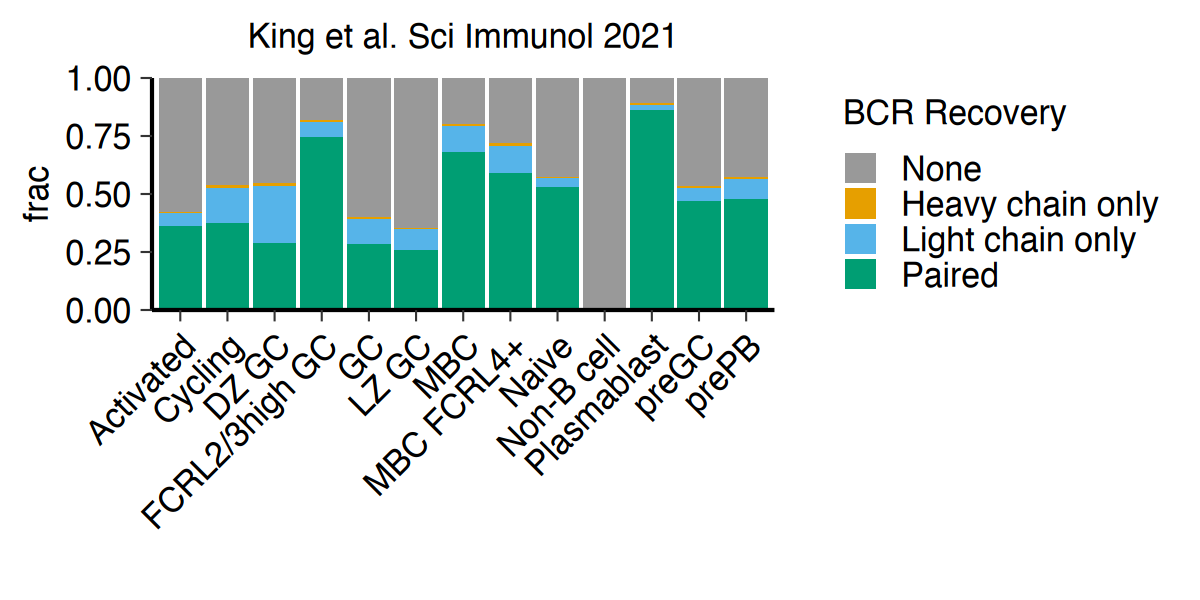

In [197]:
options(repr.plot.width=4,repr.plot.height=2,repr.plot.res=300)

metadata %>% 
ggplot(aes(x=cell.type, fill=recovery)) + theme_classic()+
geom_bar(position='fill') + 
labs(x='',y='frac',fill='BCR Recovery',title='King et al. Sci Immunol 2021')+
scale_y_continuous(expand=c(0,0))+
scale_fill_manual(values = c("#999999", "#E69F00", "#56B4E9", "#009E73")) +
Axis_themes+
theme(axis.text.x=element_text(angle=45,hjust=1),
      legend.key.size = unit(.3, 'cm'))

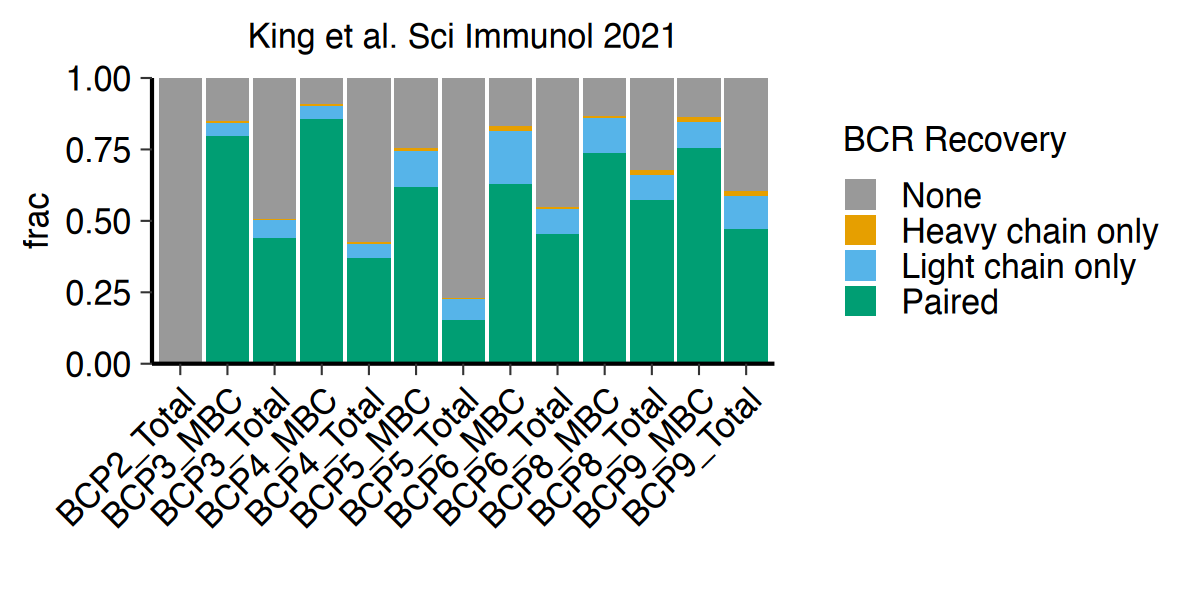

In [200]:
options(repr.plot.width=4,repr.plot.height=2,repr.plot.res=300)

metadata %>% 
ggplot(aes(x=sample, fill=recovery)) + theme_classic()+
geom_bar(position='fill') + 
labs(x='',y='frac',fill='BCR Recovery',title='King et al. Sci Immunol 2021')+
scale_y_continuous(expand=c(0,0))+
scale_fill_manual(values = c("#999999", "#E69F00", "#56B4E9", "#009E73")) +
Axis_themes+
theme(axis.text.x=element_text(angle=45,hjust=1),
      legend.key.size = unit(.3, 'cm'))

In [296]:
write.csv(metadata,'King_etal_metadata_recovery_labeled.csv')

In [370]:
metadata = read.csv('King_etal_metadata_recovery_labeled.csv',row.names=1)
none = metadata %>% count(sample,cell.type,none) %>% group_by(sample,cell.type) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(none==1) 
heavy = metadata %>% count(sample,cell.type,heavy) %>% group_by(sample,cell.type) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(heavy==1)
light = metadata %>% count(sample,cell.type,light) %>% group_by(sample,cell.type) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(light==1)
paired = metadata %>% count(sample,cell.type,paired) %>% group_by(sample,cell.type) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(paired==1)
df1 = none %>% rename('recovery'='none') %>% mutate(recovery='None')
df2 = heavy %>% rename('recovery'='heavy') %>% mutate(recovery='Heavy')
df3 = light %>% rename('recovery'='light') %>% mutate(recovery='Light')
df4 = paired %>% rename('recovery'='paired') %>% mutate(recovery='Paired')
bcells = rbind(df1,df2, df3, df4) %>% filter(ncell>1)

In [371]:
# all bcell 
none = metadata %>% filter(cell.type!='Non-B cell') %>% count(sample,none) %>% group_by(sample) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(none==1) 
heavy = metadata %>% filter(cell.type!='Non-B cell') %>% count(sample,heavy) %>% group_by(sample) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(heavy==1)
light = metadata %>% filter(cell.type!='Non-B cell') %>% count(sample,light) %>% group_by(sample) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(light==1)
paired = metadata %>% filter(cell.type!='Non-B cell') %>% count(sample,paired) %>% group_by(sample) %>% mutate(ncell = sum(n),frac=n/ncell) %>% filter(paired==1)

df1 = none %>% rename('recovery'='none') %>% mutate(recovery='None')
df2 = heavy %>% rename('recovery'='heavy') %>% mutate(recovery='Heavy')
df3 = light %>% rename('recovery'='light') %>% mutate(recovery='Light')
df4 = paired %>% rename('recovery'='paired') %>% mutate(recovery='Paired')
allbcell = rbind( df1,df2, df3, df4) %>% filter(ncell>1)
allbcell$cell.type = 'All B cells'

In [372]:
df4gg=rbind(bcells,allbcell)
df4gg2 = df4gg %>% group_by(recovery,cell.type) %>% 
summarize(mean.frac= mean(frac),sd.frac=sd(frac),se.frac=sd.frac/sqrt(n())) %>% replace(is.na(.),0)

df4gg$recovery = factor(df4gg$recovery,levels=c('None','Heavy','Light','Paired'))
df4gg2$recovery = factor(df4gg2$recovery,levels=c('None','Heavy','Light','Paired'))
df4gg$cell.type = factor(df4gg$cell.type,levels=c('Non-B cell','Naive','Activated','MBC','MBC FCRL4+',
                                                  'preGC','Cycling','DZ GC','FCRL2/3high GC',
                                                  'GC','LZ GC','prePB','Plasmablast','All B cells'))
df4gg2$cell.type = factor(df4gg2$cell.type,levels=c('Non-B cell','Naive','Activated','MBC','MBC FCRL4+',
                                                  'preGC','Cycling','DZ GC','FCRL2/3high GC',
                                                  'GC','LZ GC','prePB','Plasmablast','All B cells'))

`summarise()` has grouped output by 'recovery'. You can override using the
`.groups` argument.


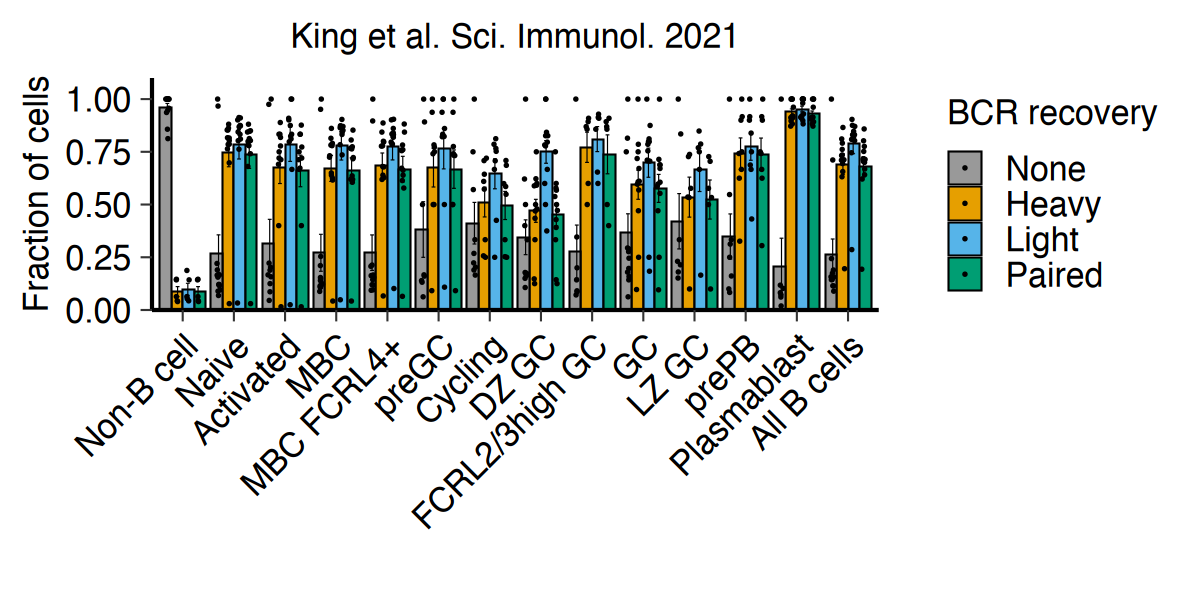

In [375]:
options(repr.plot.width=4,repr.plot.height=2,repr.plot.res=300)
dodgewidth=0.8
df4gg2 %>% 
ggplot(aes(x=cell.type,fill=recovery)) + theme_classic()+ 
geom_bar(aes(y=mean.frac),stat='identity', position='dodge', color = 'black', linewidth = .177) + 
geom_errorbar(aes(ymin = mean.frac-se.frac, ymax = mean.frac+se.frac),width=0.3,
              position = position_dodge(width = dodgewidth),linewidth=0.1)+
geom_point(data=df4gg, aes(x=cell.type, y=frac), size= .2, color = 'black',stroke=0.2,
           position = position_jitterdodge(dodge.width = dodgewidth, jitter.width = .2))+
#geom_jitter(aes(y=frac),size=0.5,position = position_dodge(width = 0.9)) + 
labs(title='King et al. Sci. Immunol. 2021',x='',y='Fraction of cells',fill='BCR recovery') + 
scale_fill_manual(values = c('None'="#999999", 'Heavy'="#E69F00", 'Light'="#56B4E9",'Paired'="#009E73")) +
scale_y_continuous(expand=c(0,0),lim=c(0,1.1)) + 
Axis_themes +
theme(axis.text.x=element_text(angle=45,hjust=1),
      legend.key.size = unit(.3, 'cm'))

out = 'figures/king_celltype_bcr_recovery_barplot.pdf'
ggsave(out, height = 2, width = 4, useDingbats = FALSE)

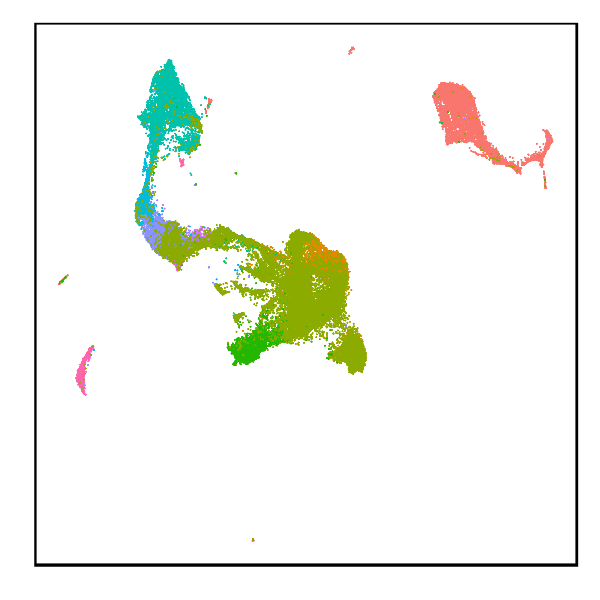

In [363]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)

metadata = read.csv('King_etal_metadata_recovery_labeled.csv',row.names=1)
metadata$cell.type = factor(metadata$cell.type,levels=c('Non-B cell','Naive','Activated','MBC','MBC FCRL4+',
                                                  'preGC','Cycling','DZ GC','FCRL2/3high GC',
                                                  'GC','LZ GC','prePB','Plasmablast','All B cells'))

metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2,color=cell.type))+ 
geom_point_rast(size = .2, stroke = 0, raster.dpi = 1000) +
#scale_color_manual(values = c('#CCCCCB','#C8E3B4','#1D91C0','#1E2456')) +
labs(color='Cell Type') +
UMAP_theme

out = 'figures/king_uamp_celltype.pdf'
ggsave(out, height = 1.8, width = 1.8, useDingbats = FALSE)

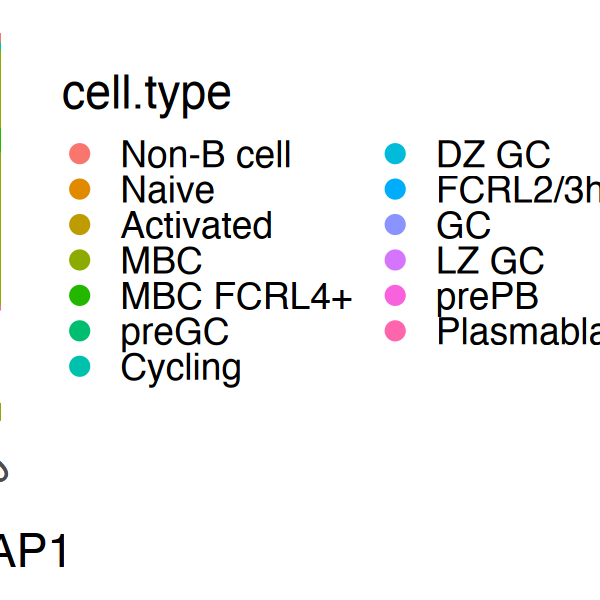

In [364]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)

metadata = read.csv('King_etal_metadata_recovery_labeled.csv',row.names=1)
metadata$cell.type = factor(metadata$cell.type,levels=c('Non-B cell','Naive','Activated','MBC','MBC FCRL4+',
                                                  'preGC','Cycling','DZ GC','FCRL2/3high GC',
                                                  'GC','LZ GC','prePB','Plasmablast'))

metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2,color=cell.type))+ theme_classic() +
geom_point() + guides(color = guide_legend(ncol = 2)) +
theme(axis.text.x=element_text(angle=45,hjust=1),
      legend.key.size = unit(.3, 'cm'))

out = 'figures/king_uamp_celltype_legend.pdf'
ggsave(out, height = 1.8, width = 1.8, useDingbats = FALSE)

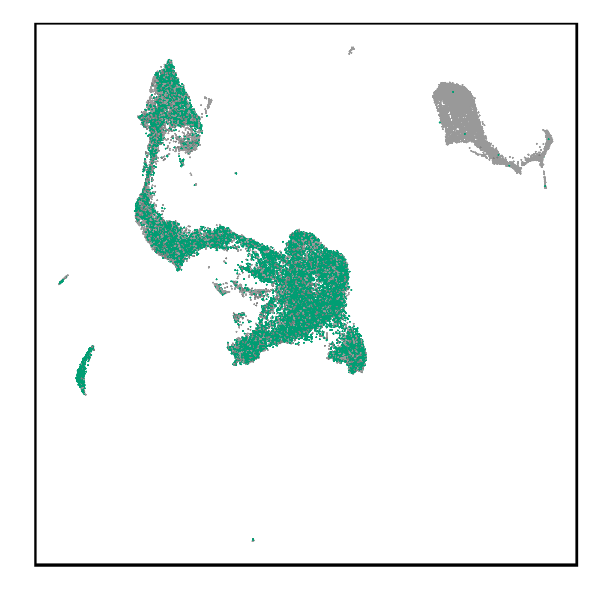

In [365]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)

metadata = read.csv('King_etal_metadata_recovery_labeled.csv',row.names=1)

metadata %>% 
ggplot(aes(x=UMAP1, y=UMAP2,color=recovery))+ 
geom_point_rast(size = .2, stroke = 0, raster.dpi = 1000) +
scale_color_manual(values = c('None'="#999999", 'Heavy'="#E69F00", 'Light'="#56B4E9",'Paired'="#009E73")) +
labs(color='Cell Type') +
UMAP_theme

out = 'figures/king_uamp_recovery.pdf'
ggsave(out, height = 1.8, width = 1.8, useDingbats = FALSE)

In [311]:
# get WTA and BCR counts 
bcell = subset(gex,Lineage=='B Cells')
bcell

An object of class Seurat 
24052 features across 43650 samples within 2 assays 
Active assay: integrated (4000 features, 4000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [351]:
# get WTA and BCR counts 
DefaultAssay(bcell) <- "RNA"
# IGH
df4gg = FetchData(bcell,jz.checkgenes(bcell,'IGH'),slot='count')
df4gg$WTA = rowSums(df4gg)
# get scVDJ umis
bcr.df = filter.bcr %>% filter(IGH_UMIS>0)
df4gg$VDJ = bcr.df$IGH_UMIS[match(rownames(df4gg), bcr.df$cell.id)]
df4gg$VDJ[is.na(df4gg$VDJ)] = 0
igh = df4gg %>% select(WTA, VDJ) %>% mutate(chain = 'IGH')

# IGK
df4gg = FetchData(bcell,jz.checkgenes(bcell,'IGK'),slot='count')
df4gg$WTA = rowSums(df4gg)
# get scVDJ umis
bcr.df = filter.bcr %>% filter(IGK_UMIS>0)
df4gg$VDJ = bcr.df$IGK_UMIS[match(rownames(df4gg), bcr.df$cell.id)]
df4gg$VDJ[is.na(df4gg$VDJ)] = 0
igk = df4gg %>% select(WTA, VDJ) %>% mutate(chain = 'IGK')

# IGL
df4gg = FetchData(bcell,jz.checkgenes(bcell,'IGL'),slot='count')
df4gg$WTA = rowSums(df4gg)
# get scVDJ umis
bcr.df = filter.bcr %>% filter(IGL_UMIS>0)
df4gg$VDJ = bcr.df$IGL_UMIS[match(rownames(df4gg), bcr.df$cell.id)]
df4gg$VDJ[is.na(df4gg$VDJ)] = 0
igl = df4gg %>% select(WTA, VDJ) %>% mutate(chain = 'IGL')

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in geom_abline(slope = 1, yintercept = 0, linetype = "dashed", color = "red", :
“Ignoring unknown parameters: `yintercept`”
Warning message in geom_abline(slope = 1, yintercept = 0, linetype = "dashed", color = "red", :
“Ignoring unknown parameters: `yintercept`”
Warning message in geom_abline(slope = 1, yintercept = 0, linetype = "dashed", color = "red", :
“Ignoring unknown parameters: `yintercept`”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in sc

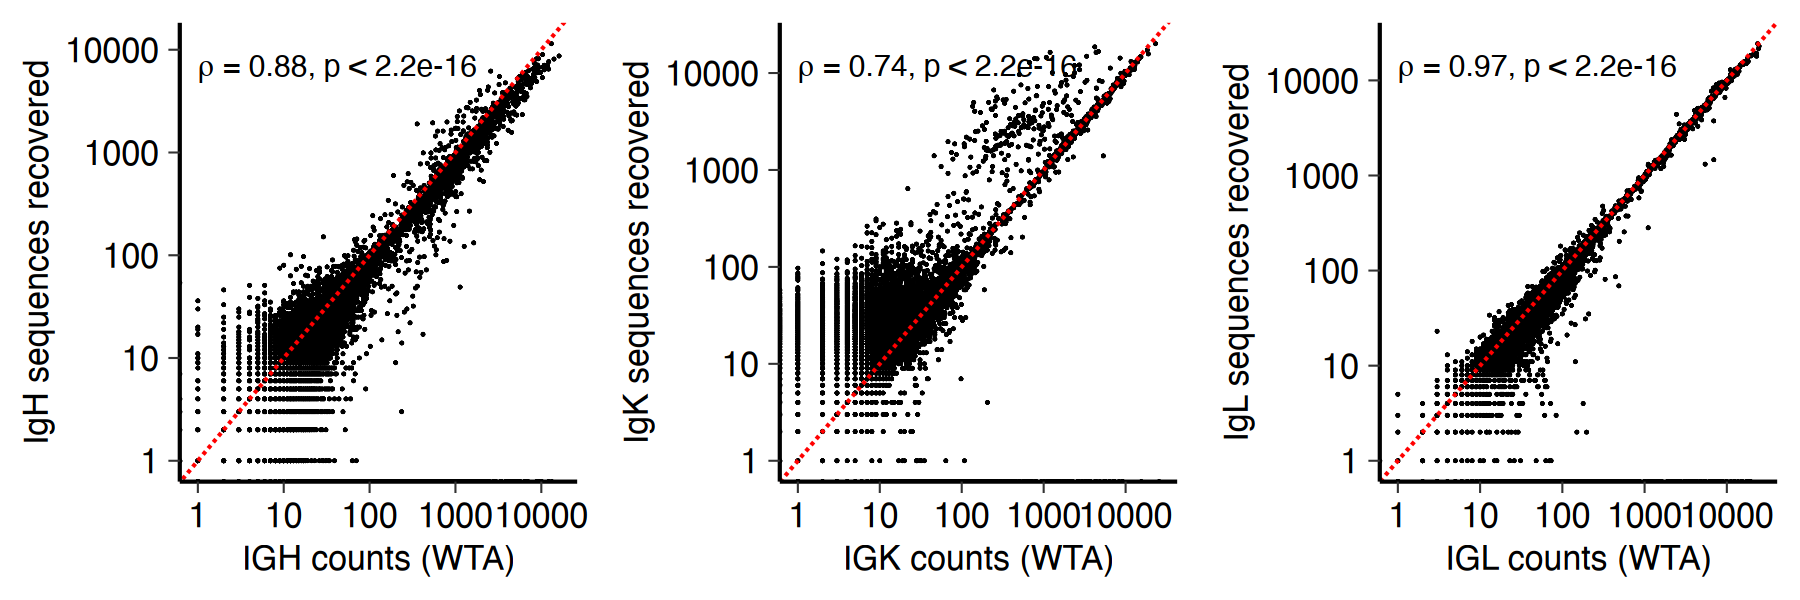

In [352]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 300)

library(ggpubr)
g1 = ggplot(igh, aes(x = WTA, y = VDJ)) + geom_point_rast(size = .4, stroke = 0.1, raster.dpi = 1000) + scale_x_log10() + scale_y_log10() + geom_abline(slope = 1, yintercept = 0, linetype = 'dashed', color = 'red', size = .355) + 
theme_classic() + Axis_themes + labs(x = 'IGH counts (WTA)', y  = 'IgH sequences recovered') + stat_cor(data = igh %>% filter(WTA>1,VDJ>1),aes(x=WTA,y=VDJ),method = 'spearman', size = 2.5, cor.coef.name = 'rho')
g1$layers[[2]]$aes_params$textsize <- 3

g2 = ggplot(igk, aes(x = WTA, y = VDJ)) + geom_point_rast(size = .4, stroke = 0.1, raster.dpi = 1000) + scale_x_log10() + scale_y_log10() + geom_abline(slope = 1, yintercept = 0, linetype = 'dashed', color = 'red', size = .355) + 
theme_classic() + Axis_themes  + labs(x = 'IGK counts (WTA)', y  = 'IgK sequences recovered') + stat_cor(data = igk %>% filter(WTA>1,VDJ>1),aes(x=WTA,y=VDJ),method = 'spearman', size = 2.5, cor.coef.name = 'rho')
g2$layers[[2]]$aes_params$textsize <- 3

g3 = ggplot(igl, aes(x = WTA, y = VDJ)) + geom_point_rast(size = .4, stroke = 0.1, raster.dpi = 1000) + scale_x_log10() + scale_y_log10() + geom_abline(slope = 1, yintercept = 0, linetype = 'dashed', color = 'red', size = .355) + 
theme_classic() + Axis_themes  + labs(x = 'IGL counts (WTA)', y  = 'IgL sequences recovered') + stat_cor(data = igl %>% filter(WTA>1,VDJ>1),aes(x=WTA,y=VDJ),method = 'spearman', size = 2.5, cor.coef.name = 'rho')
g3$layers[[2]]$aes_params$textsize <- 3


cowplot::plot_grid(g1, g2, g3, ncol = 3)
# out = 'figures/10x_3p_corplots.pdf'
# ggsave(out,device='pdf', width = 6.7, height = 6.8/3,
#        dpi = 300,useDingbats = FALSE)

In [354]:
out.df = rbind(igh,igk,igl) %>% 
mutate(exp=str_extract(rownames(.), "^[^_]+_[^_]+"),
       project='10x 5`GEX - King et al. 2021')
head(out.df)

,WTA,VDJ,chain,exp,project
,<dbl>,<dbl>,<chr>,<chr>,<chr>
BCP3_MBC_AAACCTGAGTTACGGG,35,32,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021
BCP3_MBC_AAAGATGTCTCACATT,45,40,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021
BCP3_MBC_AAAGCAACACCAGATT,3254,2666,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021
BCP3_MBC_AACACGTCAATGAATG,16,8,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021
BCP3_MBC_AACCATGAGCGCCTTG,23,16,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021
BCP3_MBC_AACCATGAGCGTTGCC,32,24,IGH,BCP3_MBC,10x 5`GEX - King et al. 2021


In [355]:
write.csv(out.df,'King_etal_cDNA_vs_VDJ.csv')

In [341]:
table(out.df$chain)


  IGH   IGK   IGL 
43650 43650 43650 

In [361]:
# recovery probability plot 
df4gg = read.csv('King_etal_cDNA_vs_VDJ.csv',row.names=1)
df4gg = df4gg %>% mutate(chain=ifelse(chain == 'IGH', 'Heavy Chain', 'Light Chain')) %>%
mutate(Recovery = ifelse(VDJ>0, 'Recovery', 'No Recovery'))

## Binning the WTA counts
df4gg$WTA.bin = cut(df4gg$WTA, c(-Inf,0,2,4,8,16,32,64,Inf)) 
# calculate fraction of recovery / no recovery 
df4gg = df4gg %>%
group_by(chain, project, exp, WTA.bin, Recovery) %>% summarise(n=n()) %>% 
group_by(chain, project, exp, WTA.bin) %>% mutate(frac = n/sum(n))

# calculate mean for recovered 
df4gg = df4gg %>% filter(Recovery == 'Recovery') %>% 
group_by(chain,project,WTA.bin) %>% 
summarise(mean.frac = mean(frac), std = sd(frac), se = std/sqrt(n())) %>% ungroup()

`summarise()` has grouped output by 'chain', 'project', 'exp', 'WTA.bin'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'chain', 'project'. You can override using
the `.groups` argument.


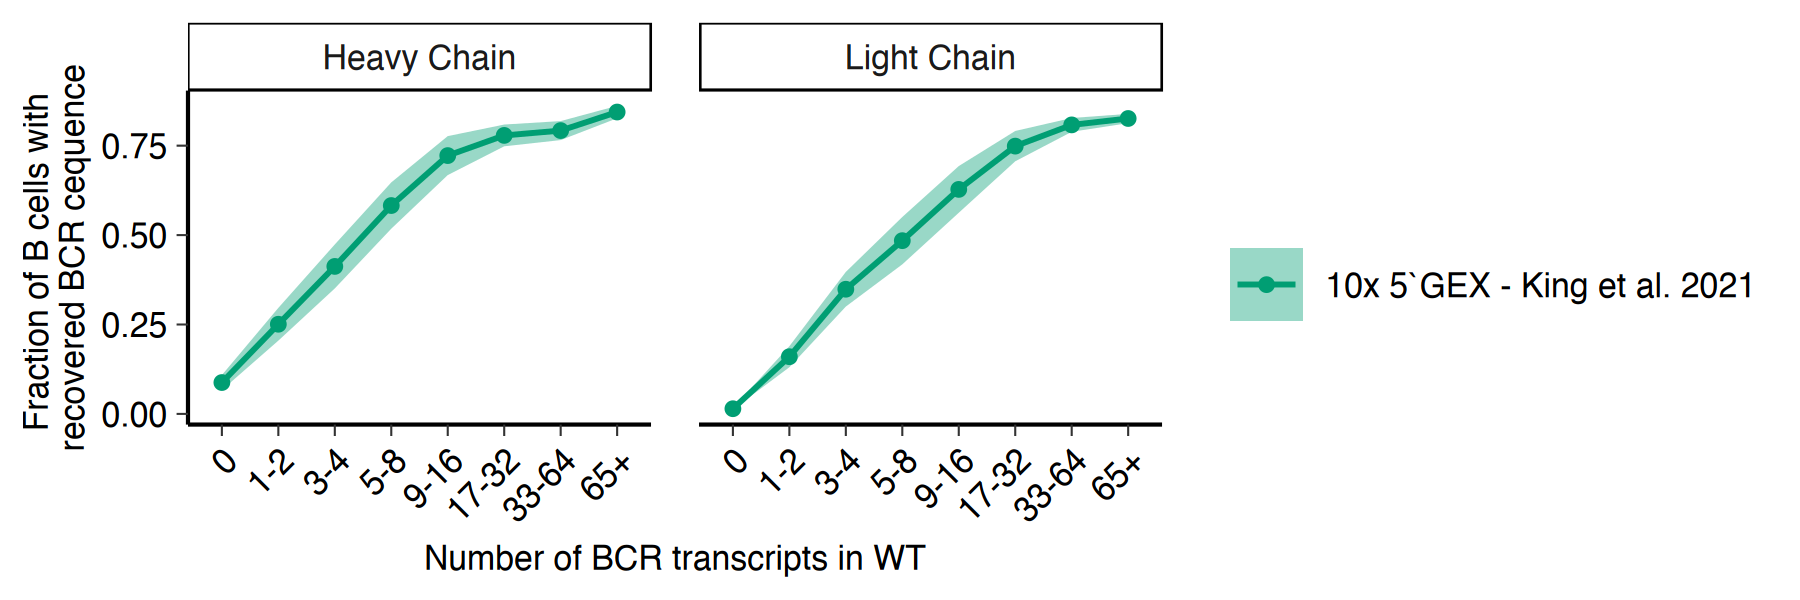

In [362]:
options(repr.plot.width=6, repr.plot.height=2, repr.plot.res=300)
col = c("#009E73", "#0072B2", "#999999", "#CC79A7" ,"#D55E00")#E69F00

df4gg %>% 
ggplot(aes(x=WTA.bin, y=mean.frac,color=project)) + theme_classic() +
geom_ribbon(aes(group=project,ymin=mean.frac-se, ymax=mean.frac+se, fill=project), linewidth=0, alpha=0.4)+
geom_line(aes(group=project),linewidth=0.5) +
geom_point(size=1) + 
scale_color_manual(values=col) +
scale_fill_manual(values=col) +
scale_x_discrete(labels=c('0','1-2','3-4','5-8','9-16','17-32','33-64','65+'))+ 
facet_wrap('chain') + 
labs(y='Fraction of B cells with \nrecovered BCR cequence', 
     x='Number of BCR transcripts in WT',color='', fill='')+
Axis_themes+
theme(panel.spacing = unit(0.8, "lines"),
      axis.text.x=element_text(angle=45,hjust=1,color = "black"))

